In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor   
from sklearn.metrics import accuracy_score, mean_squared_error, recall_score, precision_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, classification_report
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

#imbalance method
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

*`This notebook uses the CRIPS-DM workflow`*
- Business Understanding
- Data Understanding
- Data Preparation
- Model Building & Testing
- Evaluation
- Deployment

<hr>

## <center> **Business Understanding**

<hr>

> #### **Context**

Customer churn rate refers to the rate at which customers stop subscribing to a service. This dataset belongs to a leading online E-commerce company. An online retail (E-commerce) company wants to identify customers who are likely to churn so they can offer promotions to retain them.

`Data Context: The dataset is divided into two parts: data_train and data_val, with data_val reserved for evaluating the modeling results from data_train. However, during the exploratory phase to understand relationships between columns (customer behavior), the data team uses the entire dataset to ensure the exploration is representative of the full dataset provided.`

> #### **Problem Statement**

The marketing team has asked the data team to build a model to predict which customers are likely to churn. Additionally, the data team will explore factors contributing to customer churn.


> #### **Goal**

The goal of the data team is to predict customer churn and offer promotions to those customers. Additionally, the data team aims to identify patterns of churn based on the predictive model.

> #### **Metric Evaluation**

Since the objective of this prediction is to minimize false negatives (customers incorrectly predicted not to churn) to avoid losing customers, and false positives (customers incorrectly predicted to churn) to avoid unnecessary promotion costs, the evaluation metrics used are:

**F1-Score**: This metric balances true positive and true negative predictions. It is the harmonic mean of precision and recall, making it suitable for cases where a balance between precision and recall is desired.

**ROC AUC Score**: This metric shows the model's ability to distinguish between classes.

<hr>

## <center>**Data Understanding**

<hr>

> #### **Load Dataset:**

In [31]:
# load dataset, identifying date-type per column, 
df = pd.read_csv("data_ecommerce_customer_churn.csv")
display(df.info())
display(df.shape)
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


None

(3941, 11)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2004,15.0,9.0,4,Grocery,4,Single,3,0,5.0,285.15,0
3795,8.0,9.0,5,Laptop & Accessory,5,Divorced,8,0,10.0,184.57,0
359,8.0,NaN,4,Mobile,5,Single,2,0,2.0,124.50,0
1452,0.0,23.0,3,Mobile,3,Married,1,1,0.0,127.41,1
1980,15.0,13.0,4,Fashion,3,Single,3,0,NaN,217.41,0




> #### **Data Overview**

The dataset provided includes various features related to customers' demographics and their interaction with the E-commerce platform. The following table outlines the key features:

| Feature                  | Data Type | Description                                                                 |
|--------------------------|-----------|-----------------------------------------------------------------------------|
| `Tenure`                 | Float     | Length of subscription in months in the range 0-72                          |
| `WarehouseToHome`        | Float     | Distance between warehouse and home in kilometers in the range 1-50         |
| `NumberOfDeviceRegistered` | Integer  | Number of registered devices in the range 1-5                               |
| `PreferedOrderCat`       | String    | Preferred order category: 'Laptop & Accessory', 'Mobile', 'Fashion', 'Others', etc. |
| `SatisfactionScore`      | Integer   | Customer satisfaction score in the range 1-5                                |
| `MaritalStatus`          | String    | Marital status: 'Single', 'Married', 'Divorced', etc.                       |
| `NumberOfAddress`        | Integer   | Number of registered addresses in the range 1-10                            |
| `Complain`               | Integer   | Whether the customer has filed a complaint or not in the range 0-1          |
| `DaySinceLastOrder`      | Float     | Number of days since the last order in the range 0-365                      |
| `CashbackAmount`         | Float     | Amount of cashback in USD in the range 0-500                                |
| `Churn`                  | Integer   | Whether the customer has churned or not in the range 0-1                    |

> #### **Separating dataset into train and test**

In [32]:
# Memisahkan data train dan data test
X = df.drop(columns=['Churn'])
y = df['Churn']
data_train, data_test = train_test_split(df, stratify=y, test_size=0.2, random_state=42)
display(data_train)
display(data_test)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2025,0.0,15.0,4,Mobile Phone,5,Married,4,0,2.0,144.00,1
3440,24.0,8.0,5,Laptop & Accessory,4,Married,6,0,2.0,154.82,0
482,9.0,9.0,5,Fashion,4,Married,4,0,NaN,227.74,0
803,NaN,8.0,3,Mobile,4,Married,2,0,2.0,122.26,0
3123,4.0,7.0,6,Mobile Phone,3,Divorced,5,0,3.0,163.33,0
...,...,...,...,...,...,...,...,...,...,...,...
2247,14.0,9.0,2,Laptop & Accessory,3,Married,7,0,9.0,188.77,0
3456,1.0,23.0,4,Fashion,5,Single,4,1,NaN,210.64,1
1646,3.0,27.0,4,Laptop & Accessory,1,Married,4,0,3.0,194.31,0
3923,4.0,26.0,1,Mobile,1,Married,1,0,2.0,127.91,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
1293,14.0,8.0,3,Grocery,5,Married,8,0,8.0,265.95,0
1635,19.0,14.0,4,Laptop & Accessory,5,Married,9,1,7.0,146.15,0
483,4.0,30.0,4,Laptop & Accessory,5,Single,2,0,8.0,168.12,0
2571,2.0,26.0,3,Mobile Phone,1,Married,2,0,10.0,138.12,0
3376,7.0,8.0,4,Mobile Phone,5,Single,2,0,3.0,143.81,0
...,...,...,...,...,...,...,...,...,...,...,...
705,NaN,12.0,3,Mobile,5,Married,5,1,2.0,120.73,1
964,0.0,11.0,4,Fashion,1,Married,2,1,NaN,228.08,0
3332,2.0,NaN,4,Mobile,1,Married,7,0,3.0,125.32,0
1466,9.0,7.0,4,Fashion,3,Single,3,0,NaN,212.89,0


- We split the dataset and into `data_train` and `data_test`. Then we save `data_test` only for evaluation. This step is underdone in order to prevent data leakage.

> #### **Indentifying Anomali:**

In [33]:
# checking any MISSING VALUES
(data_train.isna().sum() / data_train.shape[0]) \
    .reset_index() \
    .rename(columns={0: 'Missing Value (%)', 'index': 'Feature Name'}) \
    .sort_values('Missing Value (%)', ascending=False)


,Feature Name,Missing Value (%)
8,DaySinceLastOrder,0.053299
0,Tenure,0.051079
1,WarehouseToHome,0.042830
2,NumberOfDeviceRegistered,0.000000
3,PreferedOrderCat,0.000000
4,SatisfactionScore,0.000000
5,MaritalStatus,0.000000
6,NumberOfAddress,0.000000
7,Complain,0.000000
9,CashbackAmount,0.000000


We found 3 columns with missing values, including:

- `DaySinceLastOrder` has a proportion of 0.05%
- `Tenure` has a proportion of 0.05%
- `WarehouseToHome` has a proportion of 0.04%

In [34]:
data_train.columns

Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus',
       'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'Churn'],
      dtype='object')

,count,mean,std,min,25%,50%,75%,max
Tenure,2991.0,10.071214,8.487367,0.0,2.0,9.0,16.0,61.0
WarehouseToHome,3017.0,15.568445,8.437202,5.0,9.0,14.0,20.0,127.0
DaySinceLastOrder,2984.0,4.543566,3.617773,0.0,2.0,3.0,7.0,31.0


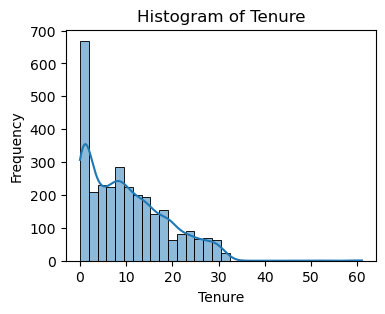

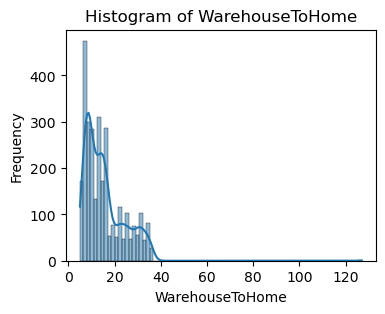

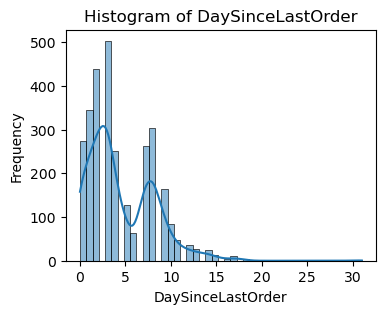

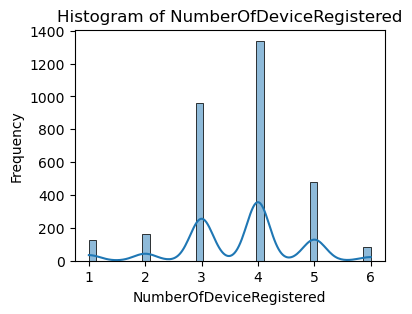

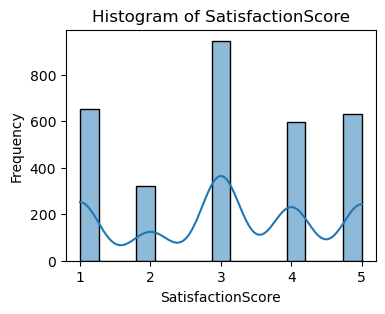

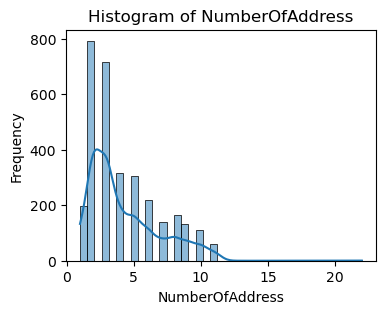

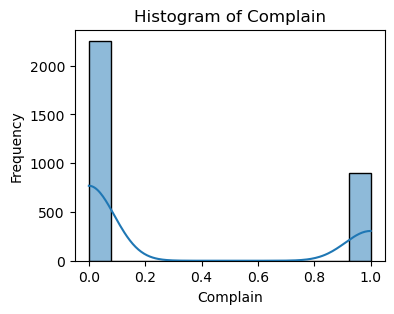

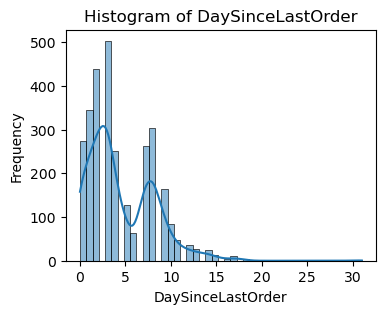

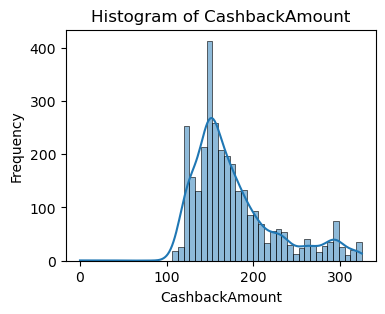

In [35]:
# checking data distribution of 'missing value' features
display(data_train[['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']].describe().T)

# a fuction for making a histogram
def plot_histogram(data, title):
    plt.figure(figsize=(4, 3))
    
    # visualizing histogram
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {title}')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    
    plt.show()

# histograms for every features
plot_histogram(data_train['Tenure'], 'Tenure')
plot_histogram(data_train['WarehouseToHome'], 'WarehouseToHome')
plot_histogram(data_train['DaySinceLastOrder'], 'DaySinceLastOrder')

plot_histogram(data_train['NumberOfDeviceRegistered'], 'NumberOfDeviceRegistered')
plot_histogram(data_train['SatisfactionScore'], 'SatisfactionScore')
plot_histogram(data_train['NumberOfAddress'], 'NumberOfAddress')
plot_histogram(data_train['Complain'], 'Complain')
plot_histogram(data_train['DaySinceLastOrder'], 'DaySinceLastOrder')
plot_histogram(data_train['CashbackAmount'], 'CashbackAmount')


- These graphs show the distribution data of numerical features. All features are not in normal distribution

- The features that have missing values (first 3 graphs) are concentrated on the left side of the graph, with the height of the bars decreasing. This indicates that most values are at the lower end and there are few high values. `This distribution is called right-skewed because the tail on the right side is longer than on the left side`.

In [36]:
data_train.select_dtypes(exclude='object').columns

Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder',
       'CashbackAmount', 'Churn'],
      dtype='object')

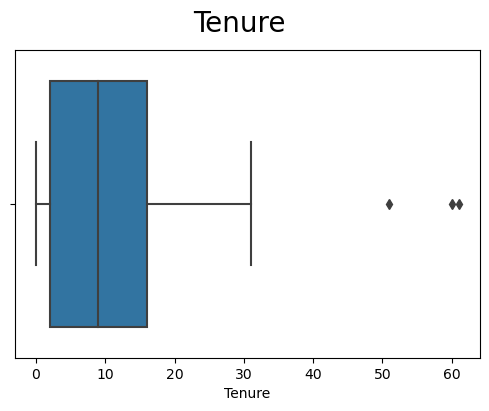

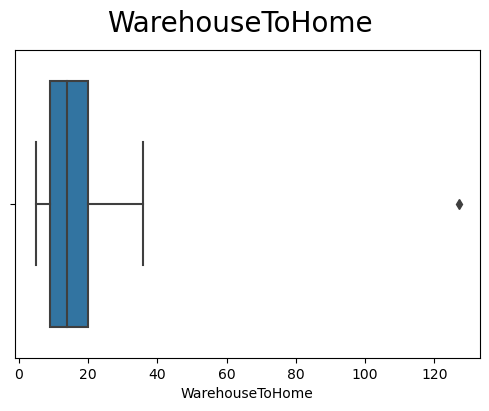

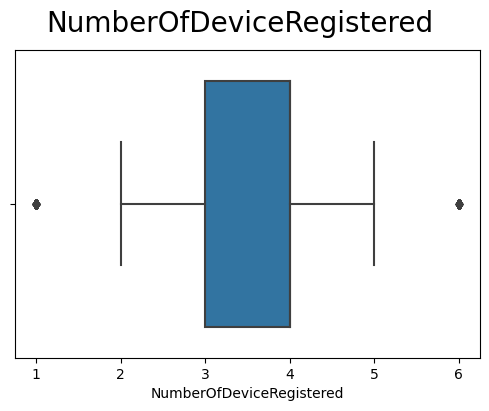

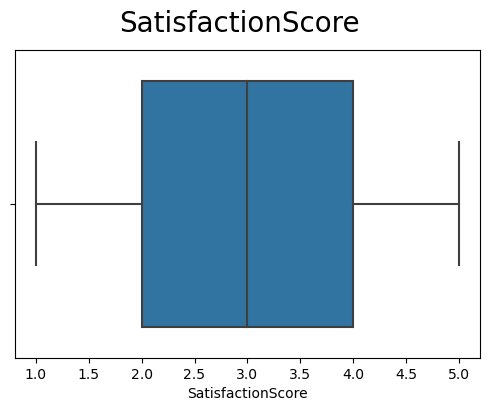

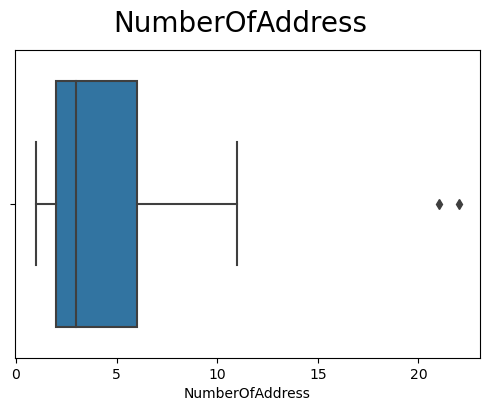

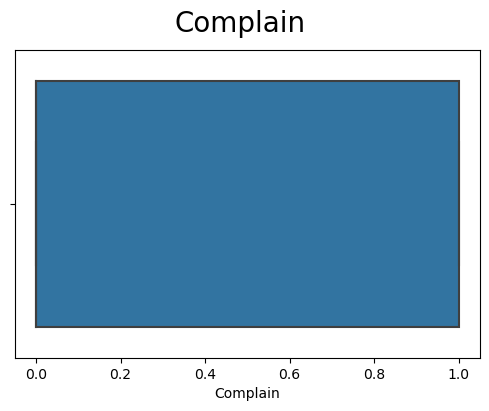

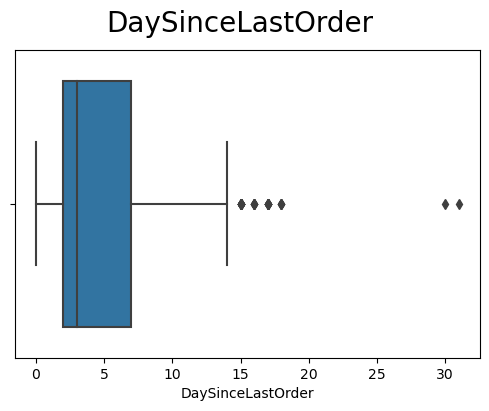

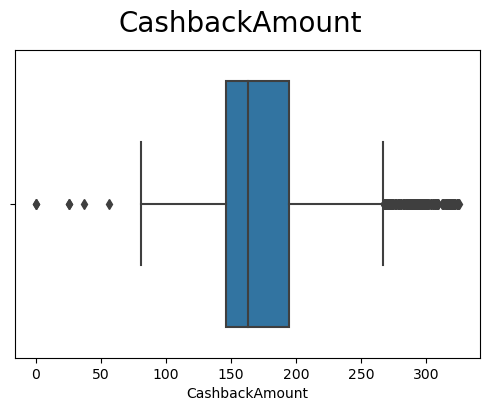

In [37]:
# checking any OUTLIERS
check_outlier = data_train[['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder',
       'CashbackAmount']]

for col in check_outlier:
    plt.figure(figsize=(6,4))
    plt.suptitle(col, fontsize=20)
    sns.boxplot(data=data_train, x=col)
    plt.show()


From the boxplot visualization, the following numeric columns have been identified to contain outliers: `Tenure`, `WarehouseToHome`, `NumberOfDeviceRegistered`, `NumberOfAddress`, `DaySinceLastOrder`, `CashbackAmount`.

In [38]:
# Checking how many records that have outliers

check_outlier_iqr = check_outlier[['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
                                   'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']]

# Calculate the interquartile range (IQR)
Q1 = check_outlier_iqr.quantile(0.25)
Q3 = check_outlier_iqr.quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ((check_outlier_iqr < lower_bound) | (check_outlier_iqr > upper_bound))

# Display the proportion of outliers for each feature
outliers_df = pd.DataFrame(index=check_outlier_iqr.columns)
outliers_df['Old Shape'] = check_outlier_iqr.shape[0]

for column in check_outlier_iqr.columns:
    outliers_df.at[column, 'New Shape'] = check_outlier_iqr[~outliers[column]].shape[0]
    outliers_df.at[column, 'Q1'] = Q1[column]
    outliers_df.at[column, 'Q3'] = Q3[column]
    outliers_df.at[column, 'IQR'] = IQR[column]
    outliers_df.at[column, 'Upper bound'] = upper_bound[column]
    outliers_df.at[column, 'Lower bound'] = lower_bound[column]

outliers_df


,Old Shape,New Shape,Q1,Q3,IQR,Upper bound,Lower bound
Tenure,3152,3149.0,2.0000,16.0000,14.00,37.0000,-19.0000
WarehouseToHome,3152,3151.0,9.0000,20.0000,11.00,36.5000,-7.5000
NumberOfDeviceRegistered,3152,2941.0,3.0000,4.0000,1.00,5.5000,1.5000
NumberOfAddress,3152,3150.0,2.0000,6.0000,4.00,12.0000,-4.0000
DaySinceLastOrder,3152,3118.0,2.0000,7.0000,5.00,14.5000,-5.5000
CashbackAmount,3152,2881.0,145.7225,194.3525,48.63,267.2975,72.7775


The DataFrame above indicates that if we decide to drop the outlier records, a total of 271 data points will be removed.

In [39]:
# checking any duplicate values or records
data_train.duplicated().sum()

440

> #### **Exploratory Data Analysis (EDA)**

In [40]:
for column in data_train.columns:
    unique_values = sorted(data_train[column].unique())
    nunique_values = data_train[column].nunique()
    print(f"Kolom: {column}")
    print(f"Unique values: {unique_values}")
    print(f"Number of unique values: {nunique_values}")
    print("-" * 50)

Kolom: Tenure
Unique values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 18.0, 20.0, 24.0, nan, 12.0, 13.0, 15.0, 16.0, 17.0, 19.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 51.0, 60.0, 61.0]
Number of unique values: 35
--------------------------------------------------
Kolom: WarehouseToHome
Unique values: [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 25.0, 27.0, 30.0, nan, 23.0, 24.0, 26.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 127.0]
Number of unique values: 33
--------------------------------------------------
Kolom: NumberOfDeviceRegistered
Unique values: [1, 2, 3, 4, 5, 6]
Number of unique values: 6
--------------------------------------------------
Kolom: PreferedOrderCat
Unique values: ['Fashion', 'Grocery', 'Laptop & Accessory', 'Mobile', 'Mobile Phone', 'Others']
Number of unique values: 6
--------------------------------------------------
Kolom: SatisfactionScore
Un

In [41]:
# checking features with object values
data_train.describe(include='object').T

,count,unique,top,freq
PreferedOrderCat,3152,6,Laptop & Accessory,1170
MaritalStatus,3152,3,Married,1643


- The category most preferred by customers is ***Laptop & Accessory***. Additionally, it can be observed that the marital status of the majority of customers is married.

In [42]:
data_train.describe(exclude='object').drop(columns='Churn').T 

,count,mean,std,min,25%,50%,75%,max
Tenure,2991.0,10.071214,8.487367,0.0,2.0000,9.00,16.0000,61.00
WarehouseToHome,3017.0,15.568445,8.437202,5.0,9.0000,14.00,20.0000,127.00
NumberOfDeviceRegistered,3152.0,3.677665,1.013791,1.0,3.0000,4.00,4.0000,6.00
SatisfactionScore,3152.0,3.072652,1.385233,1.0,2.0000,3.00,4.0000,5.00
NumberOfAddress,3152.0,4.224619,2.606230,1.0,2.0000,3.00,6.0000,22.00
Complain,3152.0,0.284264,0.451135,0.0,0.0000,0.00,1.0000,1.00
DaySinceLastOrder,2984.0,4.543566,3.617773,0.0,2.0000,3.00,7.0000,31.00
CashbackAmount,3152.0,176.743595,48.987207,0.0,145.7225,162.72,194.3525,324.99


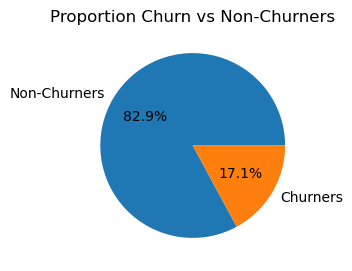

In [43]:
# checking Churners vs Non-Churners 
churn_counts = data_train['Churn'].value_counts()

# showing proportion Churners vs Non-Churners 
plt.figure(figsize=(3, 3))
plt.pie(churn_counts, labels=['Non-Churners', 'Churners'], autopct='%1.1f%%')
plt.title('Proportion Churn vs Non-Churners')
plt.show()


- The proportion of Churn vs Non-Churn is 83% : 17%. This indicates an imbalance class in the dataset flag.

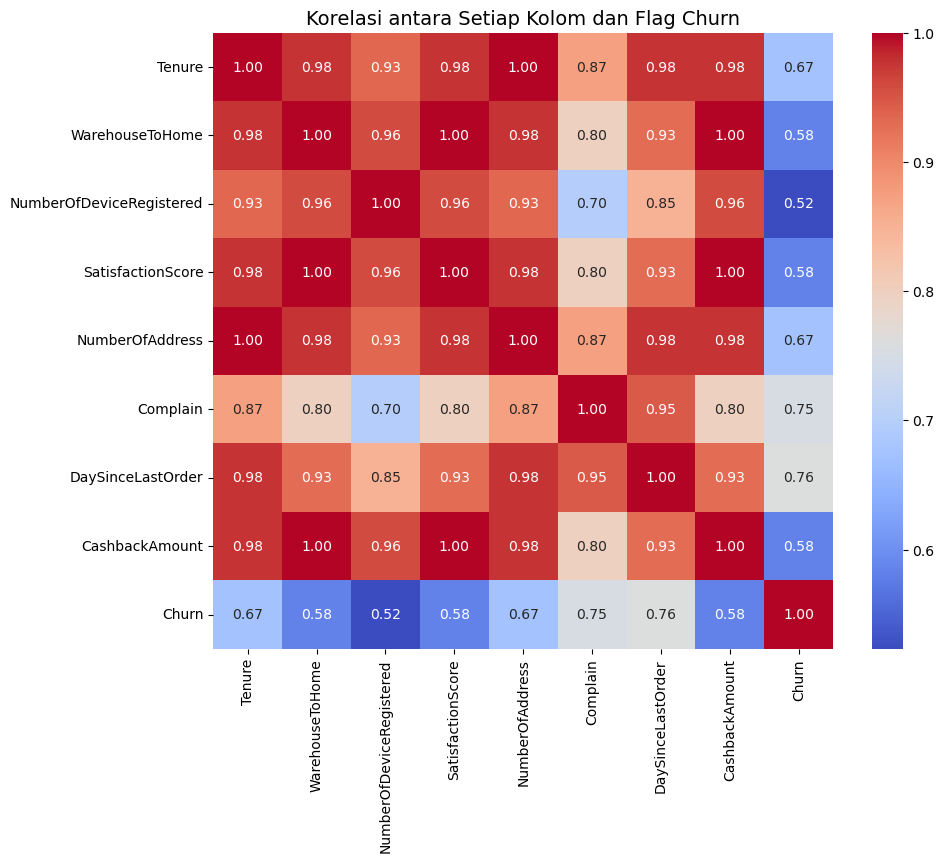

In [44]:
plt.figure(figsize=(10, 8))
correlation_matrix = data_train.describe(exclude='object').corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi antara Setiap Kolom dan Flag Churn', fontsize=14)
plt.show()


- Spearman correlation test is used due to the visualization of data distribution indicating right-skewness.
- The correlation test results suggest that the four columns most influencing the churn label are `DaySinceLastOrder`, `Complain`, `Tenure`, and `NumberOfAddress`.

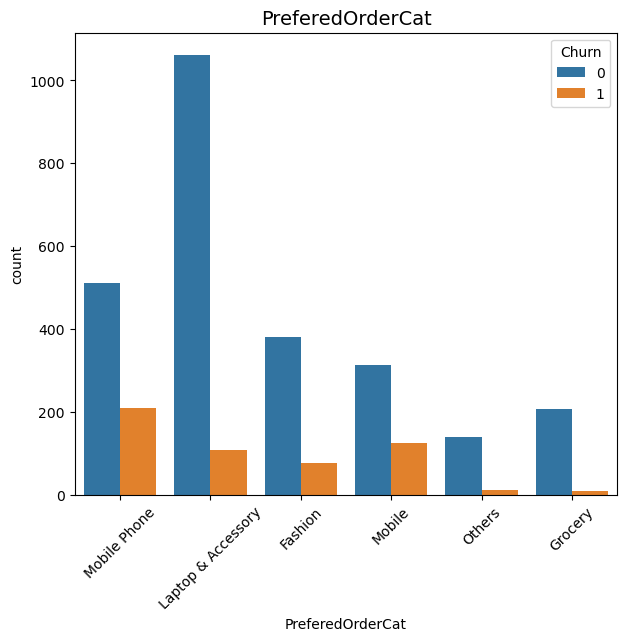

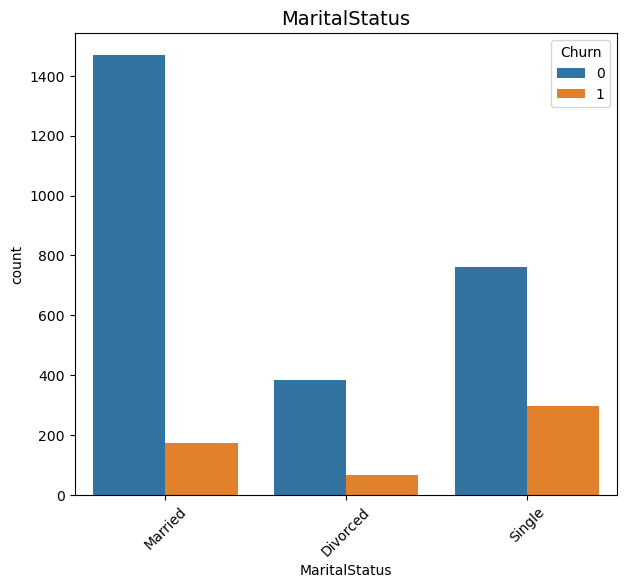

In [45]:
for col in data_train.describe(include='object').columns:
    plt.figure(figsize=(7,6))
    sns.countplot(data=data_train, x=col, hue='Churn')
    plt.title(col, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

- Customers who most frequently churn are those who prefer using smartphones and are still unmarried.
- This categorical information does not possess hierarchical levels. Therefore, to encode this data, we can use binary encoding and one-hot encoding methods.

Features with high multicollinearity:
[['Tenure', 'Tenure'], ['WarehouseToHome', 'WarehouseToHome'], ['NumberOfDeviceRegistered', 'NumberOfDeviceRegistered'], ['SatisfactionScore', 'SatisfactionScore'], ['NumberOfAddress', 'NumberOfAddress'], ['Complain', 'Complain'], ['DaySinceLastOrder', 'DaySinceLastOrder'], ['CashbackAmount', 'CashbackAmount'], ['Churn', 'Churn']]


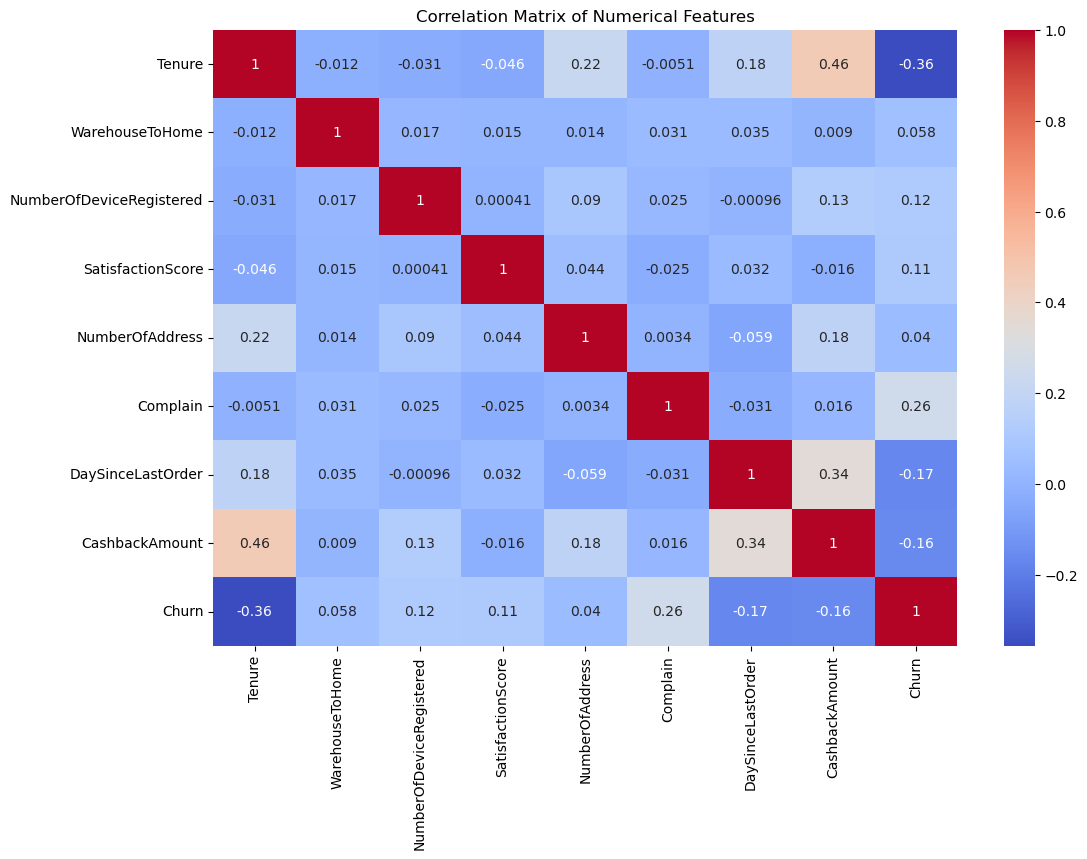

In [46]:
# check multicolineraity numerical features

dfcorr = data_train.select_dtypes(include='number')
corrMatrix = dfcorr.corr()

already_in = set()
result = []
for col in corrMatrix:
    large_corr = corrMatrix[col][corrMatrix[col] > 0.5].index.tolist()
    if large_corr and col not in already_in:
        already_in.update(set(large_corr))
        large_corr.append(col)
        result.append(large_corr)

print("Features with high multicollinearity:")
print(result)

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

- Based on the assessment of multicollinearity, it is determined that each feature does not exhibit multicollinearity with other features.

<hr>

## <center>**Data Preparation**

<hr>

> #### **Handling Duplicate**

*Handling duplicate records by droping them*

In [47]:
data_train_prep = data_train.drop_duplicates(subset=None, keep='first').reset_index(drop=True)
data_train_prep


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,0.0,15.0,4,Mobile Phone,5,Married,4,0,2.0,144.00,1
1,24.0,8.0,5,Laptop & Accessory,4,Married,6,0,2.0,154.82,0
2,9.0,9.0,5,Fashion,4,Married,4,0,NaN,227.74,0
3,NaN,8.0,3,Mobile,4,Married,2,0,2.0,122.26,0
4,4.0,7.0,6,Mobile Phone,3,Divorced,5,0,3.0,163.33,0
...,...,...,...,...,...,...,...,...,...,...,...
2707,4.0,11.0,3,Laptop & Accessory,5,Single,1,0,7.0,199.36,0
2708,14.0,9.0,2,Laptop & Accessory,3,Married,7,0,9.0,188.77,0
2709,3.0,27.0,4,Laptop & Accessory,1,Married,4,0,3.0,194.31,0
2710,4.0,26.0,1,Mobile,1,Married,1,0,2.0,127.91,0


In [48]:
# Display the proportion of data before vs after handling duplicate
duplicate_row = pd.DataFrame(index=['Total Rows'])
duplicate_row['Before Handling Duplicate'] = data_train.shape[0]
duplicate_row['After Handling Duplicate'] = data_train_prep.shape[0]

duplicate_row

,Before Handling Duplicate,After Handling Duplicate
Total Rows,3152,2712


- Handling duplicate records is necessary to ensure that the model can learn from data efficiently (avoid learning repeatedly from the same records).

> #### **Handling Outliers**

*Handling outliers records by droping them*

In [49]:
# Display the proportion of data before vs after handling outliers
outliers_row = pd.DataFrame(index=['Total Rows'])
outliers_row['Before Handling Outliers'] = data_train_prep.shape[0]
outliers_row['After Handling Outliers'] = data_train_prep.shape[0] - 271

outliers_row

,Before Handling Outliers,After Handling Outliers
Total Rows,2712,2441


- Handling outliers results in a reduced amount of remaining data; therefore, it is decided not to remove outliers.

> ##### **Handling Missing Values**
*Handing Missing Values with Imputer*

In [50]:
def handle_miss_val(met):
    missing_col = ['DaySinceLastOrder', 'Tenure', 'WarehouseToHome']
    data_train_prep1 = data_train_prep.copy()
    
    # Imputer initialization
    if met == 'median':
        method = SimpleImputer(missing_values = np.nan, strategy ='median')
    elif met == 'knn3':
        method = KNNImputer(n_neighbors=3)
    elif met == 'knn5':
        method = KNNImputer(n_neighbors=5)


    # Fit & Transform
    method.fit(data_train_prep1[missing_col])
    method = method.transform(data_train_prep1[missing_col])
    
    df = pd.DataFrame(columns = missing_col,
                      data = method)
    data_train_prep1[missing_col] = method
    
    return data_train_prep1

# Put in dataframe
missing_col = ['DaySinceLastOrder', 'Tenure', 'WarehouseToHome']
data_train_prep1 = data_train_prep.copy()

impute_median = handle_miss_val('median')
impute_knn3 = handle_miss_val('knn3')
impute_knn5 = handle_miss_val('knn5')

In [51]:
# Recalculate
def calculate(df, metrics):
    if metrics == 'std':
        return  round(df['DaySinceLastOrder'].std(), 2), round(df['Tenure'].std(), 2), round(df['WarehouseToHome'].std(), 2)
    else:
        return  round(df['DaySinceLastOrder'].mean(), 2), round(df['Tenure'].mean(), 2), round(df['WarehouseToHome'].mean(), 2)
    
# Calculate standard with missing value
day_mean = round(data_train_prep['DaySinceLastOrder'].mean(), 2)
day_std = round(data_train_prep['DaySinceLastOrder'].std(), 2)

tenure_mean = round(data_train_prep['Tenure'].mean(), 2)
tenure_std = round(data_train_prep['Tenure'].std(), 2)

warehouse_mean = round(data_train_prep['WarehouseToHome'].mean(), 2)
warehouse_std = round(data_train_prep['WarehouseToHome'].std(), 2)

# MEDIAN
day_mean_si_median, tenure_mean_si_median, warehouse_mean_si_median = calculate(impute_median, 'mean')
day_std_si_median, tenure_std_si_median, warehouse_std_si_median = calculate(impute_median, 'std')

# KNN3
day_mean_si_knn3, tenure_mean_si_knn3, warehouse_mean_si_knn3 = calculate(impute_knn3, 'mean')
day_std_si_knn3, tenure_std_si_knn3, warehouse_std_si_knn3 = calculate(impute_knn3, 'std')

# KNN5
day_mean_si_knn5, tenure_mean_si_knn5, warehouse_mean_si_knn5 = calculate(impute_knn5, 'mean')
day_std_si_knn5, tenure_std_si_knn5, warehouse_std_si_knn5 = calculate(impute_knn5, 'std')

In [52]:
result_handle_missval = pd.DataFrame(columns = ['Columns Name', 'Kind of Imputer', 'Mean Value Before', 'Mean Value After', 'Std Value Before', 'Std Value After'],
                       data = [['DaySinceLastOrder', 'Median Imputer', day_mean, day_mean_si_median, day_std, day_std_si_median], 
                               ['Tenure', 'Median Imputer', tenure_mean, tenure_mean_si_median, tenure_std, tenure_std_si_median], 
                               ['WarehouseToHome', 'Median Imputer', warehouse_mean, warehouse_mean_si_median, warehouse_std, warehouse_std_si_median],
                               
                               ['DaySinceLastOrder', 'KNN Imputer 3', day_mean, day_mean_si_knn3, day_std, day_std_si_knn3], 
                               ['Tenure', 'KNN Imputer 3', tenure_mean, tenure_mean_si_knn3, tenure_std, tenure_std_si_knn3], 
                               ['WarehouseToHome', 'KNN Imputer 3', warehouse_mean, warehouse_mean_si_knn3, warehouse_std, warehouse_std_si_knn3],
                               
                               ['DaySinceLastOrder', 'KNN Imputer 5', day_mean, day_mean_si_knn5, day_std, day_std_si_knn5], 
                               ['Tenure', 'KNN Imputer 5', tenure_mean, tenure_mean_si_knn5, tenure_std, tenure_std_si_knn5], 
                               ['WarehouseToHome', 'KNN Imputer 5', warehouse_mean, warehouse_mean_si_knn5, warehouse_std, warehouse_std_si_knn5]])

display(result_handle_missval.set_index('Columns Name').sort_values(by='Columns Name'))


,Kind of Imputer,Mean Value Before,Mean Value After,Std Value Before,Std Value After
Columns Name,,,,,
DaySinceLastOrder,Median Imputer,4.57,4.48,3.63,3.54
DaySinceLastOrder,KNN Imputer 3,4.57,4.46,3.63,3.58
DaySinceLastOrder,KNN Imputer 5,4.57,4.48,3.63,3.56
Tenure,Median Imputer,10.22,10.16,8.62,8.40
Tenure,KNN Imputer 3,10.22,10.23,8.62,8.46
Tenure,KNN Imputer 5,10.22,10.10,8.62,8.45
WarehouseToHome,Median Imputer,15.44,15.34,8.55,8.39
WarehouseToHome,KNN Imputer 3,15.44,15.42,8.55,8.43
WarehouseToHome,KNN Imputer 5,15.44,15.35,8.55,8.41


- It appears that the KNN Imputer with k = 3 displays imputation results that closely resemble the distribution of data before imputation. This will be included in the pipeline.

<hr>

# <center>**Model Building and Testing**

<hr>

> #### Modeling Part 1: Parameter Default

In [53]:
# Handling missing values and categorical encoding
categorical_features = ['PreferedOrderCat', 'MaritalStatus']
numerical_features = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 
                      'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [54]:
# Define feature and label
# Data Train
X_train = data_train_prep.drop(columns=['Churn'])
y_train = data_train_prep['Churn']

# Data Test
X_test = data_test.drop(columns=['Churn'])
y_test = data_test['Churn']

In [55]:
# Define models
logreg = LogisticRegression() 
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

models = [logreg, knn, tree, rf, xgb]
algoritma = ['Logistic Regression', 'KNN', 'Decision Tree', 'RF', 'XGBoost']

# Initialize results dictionary
results = {}

# Stratified K-Fold
sk_fold = StratifiedKFold(n_splits=5)

# Lists for storing test metrics
roc_auc_score_testing = [] 
recall_score_testing = []
f1_score_testing = []
class_report_testing = []
confus_matrix_testing = []
fpr_testing = []

# Loop over each model
for model, name in zip(models, algoritma): 
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Cross-validation
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=sk_fold, scoring='f1')
    
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    confus_matrix_var = confusion_matrix(y_test, y_pred)
    
    # Store test metrics
    roc_auc_score_testing.append(roc_auc_score(y_test, y_pred_proba))
    recall_score_testing.append(recall_score(y_test, y_pred))
    f1_score_testing.append(f1_score(y_test, y_pred))
    class_report_testing.append(classification_report(y_test, y_pred))
    confus_matrix_testing.append(confus_matrix_var)
    fpr_testing.append(confus_matrix_var[0][1] / (confus_matrix_var[0][1] + confus_matrix_var[0][0]))
    
    # Store results
    results[name] = {
        'cv_accuracy': cv_results.mean(),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confus_matrix_var,
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'fpr': confus_matrix_var[0][1] / (confus_matrix_var[0][1] + confus_matrix_var[0][0])
    }

# Create DataFrame for test metrics
df_default_test = pd.DataFrame(data={
    'Algorithm': algoritma,
    'ROC AUC Score': roc_auc_score_testing,
    'F1 Score': f1_score_testing
})

# Display results
display(df_default_test)

for i, name in enumerate(algoritma):
    print(f'Model Name: {name}\n {class_report_testing[i]}')
    print(f'{confus_matrix_testing[i]}\n')


,Algorithm,ROC AUC Score,F1 Score
0,Logistic Regression,0.846698,0.396040
1,KNN,0.819991,0.436548
2,Decision Tree,0.815511,0.707692
3,RF,0.940882,0.751055
4,XGBoost,0.942191,0.752066


Model Name: Logistic Regression
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       654
           1       0.60      0.30      0.40       135

    accuracy                           0.85       789
   macro avg       0.73      0.63      0.65       789
weighted avg       0.82      0.85      0.82       789

[[627  27]
 [ 95  40]]

Model Name: KNN
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       654
           1       0.69      0.32      0.44       135

    accuracy                           0.86       789
   macro avg       0.78      0.64      0.68       789
weighted avg       0.84      0.86      0.84       789

[[635  19]
 [ 92  43]]

Model Name: Decision Tree
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       654
           1       0.74      0.68      0.71       135

    accuracy                           0.90       789
   

> #### **Feature Importance**

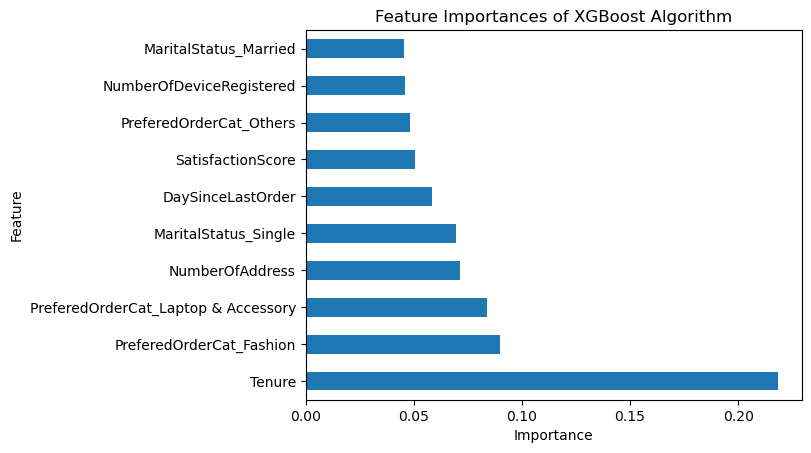

In [ ]:

# Define models
xgb = XGBClassifier(verbosity=0, silent=True)

mods = [xgb]
mods_title = ['XGBoost']
feature_final = numerical_features + preprocessor.transformers_[1][1].get_feature_names_out(categorical_features).tolist()

for i, model in enumerate(mods):
    pipeline_model = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    pipeline_model.fit(X_train, y_train)
    
    feat_imp = pd.Series(pipeline_model['model'].feature_importances_, index=feature_final)\
               .sort_values(ascending=False).head(10)
    feat_imp.plot(kind='barh', title=f'Feature Importances of {mods_title[i]} Algorithm')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


- The model with high F1 score and ROC-AUC is XGBoost. After that, we will attempt to apply resampling treatment to address the imbalanced classification.

<hr>

## <center>**Evaluation**

<hr>

> #### **Imbalance Classification Handling**
*Handing Imbalance using Resampling Method*

Based on the conducted Exploratory Data Analysis (EDA), it is known that the proportion of the Churn label/flag indicates imbalance, which may cause the model to tend to predict negative classes.

Therefore, imbalanced handling should be performed using undersampling and oversampling methods.

> #### Modeling Part 2: Imbalance Classification Handling
*Resampng Method*

In [ ]:
# Inisialize model
xgb = XGBClassifier()

# Stratified K-Fold
sk_fold = StratifiedKFold(n_splits=5)

# Lists for saving metrik result
results = {
    'method': [],
    'f1_score': [],
    'roc_auc_score': []
}

def evaluate_model(pipeline, X_train, y_train, X_test, y_test, method_name):
    # Cross-validation
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=sk_fold, scoring='f1')
    
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store metrics
    results['method'].append(method_name)
    results['f1_score'].append(f1)
    results['roc_auc_score'].append(roc_auc)
    
    return classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

# No sampling
pipeline_no_sampling = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

report_no_sampling, matrix_no_sampling = evaluate_model(pipeline_no_sampling, X_train, y_train, X_test, y_test, 'No Sampling')

# Undersampling
pipeline_undersampling = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(sampling_strategy=0.8)),  # Under-sampling
    ('model', xgb)
])

report_undersampling, matrix_undersampling = evaluate_model(pipeline_undersampling, X_train, y_train, X_test, y_test, 'Undersampling')

# Oversampling
pipeline_oversampling = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', SMOTE(sampling_strategy=0.5)),  # Over-sampling
    ('model', xgb)
])

report_oversampling, matrix_oversampling = evaluate_model(pipeline_oversampling, X_train, y_train, X_test, y_test, 'Oversampling')

# DataFrame results
df_comparison = pd.DataFrame(results)

# Display results
display(df_comparison)

print("No Sampling\n", report_no_sampling)
print(matrix_no_sampling)

print("Undersampling\n", report_undersampling)
print(matrix_undersampling)

print("Oversampling\n", report_oversampling)
print(matrix_oversampling)


,method,f1_score,roc_auc_score
0,No Sampling,0.752066,0.942191
1,Undersampling,0.687117,0.913535
2,Oversampling,0.728033,0.944161


No Sampling
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       654
           1       0.85      0.67      0.75       135

    accuracy                           0.92       789
   macro avg       0.89      0.82      0.85       789
weighted avg       0.92      0.92      0.92       789

[[638  16]
 [ 44  91]]
Undersampling
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       654
           1       0.59      0.83      0.69       135

    accuracy                           0.87       789
   macro avg       0.77      0.85      0.80       789
weighted avg       0.90      0.87      0.88       789

[[575  79]
 [ 23 112]]
Oversampling
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       654
           1       0.84      0.64      0.73       135

    accuracy                           0.92       789
   macro avg       0.88      0.81      0

- After applying resampling treatment, the results showed that no sampling provided the best performance based on F1 Score and ROC AUC Score. Therefore, it was decided not to include resampling methods in the subsequent model building.

> #### **Feature Engineering**
*Feature Engineering using K-Means Clustering*

In [ ]:

# Define K-Means Clustering as part of the pipeline

class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def transform(self, X, y=None):
        clusters = self.kmeans.predict(X)
        return np.column_stack((X, clusters))

kmeans_transformer = KMeansTransformer()

In [55]:
# Inisialize model
xgb = XGBClassifier()

# Stratified K-Fold
sk_fold = StratifiedKFold(n_splits=5)

# Lists for saving metrik result
results = {
    'method': [],
    'f1_score': [],
    'roc_auc_score': []
}


def evaluate_model(pipeline, X_train, y_train, X_test, y_test, method_name):
    # Cross-validation
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=sk_fold, scoring='f1')
    
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store metrics
    results['method'].append(method_name)
    results['f1_score'].append(f1)
    results['roc_auc_score'].append(roc_auc)
    
    return classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Tanpa KMeans
pipeline_no_kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

report_no_kmeans, matrix_no_kmeans = evaluate_model(pipeline_no_kmeans, X_train, y_train, X_test, y_test, 'No KMeans')

# Dengan KMeans
pipeline_kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans_transformer),
    ('model', xgb)
])

report_kmeans, matrix_kmeans = evaluate_model(pipeline_kmeans, X_train, y_train, X_test, y_test, 'With KMeans')

# Print reports and confusion matrices
print(f"Algorithm: XGBoost - No KMeans\n", report_no_kmeans)
print(matrix_no_kmeans)
print(f"Algorithm: XGBoost - With KMeans\n", report_kmeans)
print(matrix_kmeans)

# Membuat DataFrame untuk hasil perbandingan
df_comparison = pd.DataFrame(results)

# Display hasil
display(df_comparison)

Algorithm: XGBoost - No KMeans
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       654
           1       0.85      0.67      0.75       135

    accuracy                           0.92       789
   macro avg       0.89      0.82      0.85       789
weighted avg       0.92      0.92      0.92       789

[[638  16]
 [ 44  91]]
Algorithm: XGBoost - With KMeans
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       654
           1       0.85      0.70      0.76       135

    accuracy                           0.93       789
   macro avg       0.89      0.84      0.86       789
weighted avg       0.92      0.93      0.92       789

[[637  17]
 [ 41  94]]


,method,f1_score,roc_auc_score
0,No KMeans,0.752066,0.942191
1,With KMeans,0.764228,0.939302


- Since we are prioritizing the F1 Score as the main evaluation metric, K-Means clustering is used.


> #### Modeling Final: Hyperparameter Tunning

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define K-Means Clustering as part of the pipeline
class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def transform(self, X, y=None):
        clusters = self.kmeans.predict(X)
        return np.column_stack((X, clusters))

kmeans_transformer = KMeansTransformer()

# Define preprocessing pipeline
categorical_features = ['PreferedOrderCat', 'MaritalStatus']
numerical_features = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 
                      'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # involving parameter remaider
)

# Define the XGBoost model
xgb = XGBClassifier()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'kmeans__n_clusters': [3, 5, 7],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0]
}

# Initialize results dictionary
results = {}

# Stratified K-Fold
sk_fold = StratifiedKFold(n_splits=5)

# Lists for storing test metrics
roc_auc_score_testing = []
recall_score_testing = []
f1_score_testing = []
class_report_testing = []
confus_matrix_testing = []
fpr_testing = []

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans_transformer),
    ('model', xgb)
])

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=sk_fold, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Cross-validation
cv_results = cross_val_score(best_model, X_train, y_train, cv=sk_fold, scoring='f1')

# Fit the best model
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
confus_matrix_var = confusion_matrix(y_test, y_pred)

# Store test metrics
roc_auc_score_testing.append(roc_auc_score(y_test, y_pred_proba))
recall_score_testing.append(recall_score(y_test, y_pred))
f1_score_testing.append(f1_score(y_test, y_pred))
class_report_testing.append(classification_report(y_test, y_pred))
confus_matrix_testing.append(confus_matrix_var)
fpr_testing.append(confus_matrix_var[0][1] / (confus_matrix_var[0][1] + confus_matrix_var[0][0]))

# Store results
results['XGBoost'] = {
    'cv_accuracy': cv_results.mean(),
    'accuracy': accuracy_score(y_test, y_pred),
    'confusion_matrix': confus_matrix_var,
    'classification_report': classification_report(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'fpr': confus_matrix_var[0][1] / (confus_matrix_var[0][1] + confus_matrix_var[0][0])
}

# Create DataFrame for test metrics
df_default_test = pd.DataFrame(data={
    'Algorithm': ['XGBoost'],
    'ROC AUC Score': roc_auc_score_testing,
    'F1 Score': f1_score_testing
})

# Display results
display(df_default_test)

# Print classification report and confusion matrix
print(f'Model Name: XGBoost\n {class_report_testing[0]}')
print(f'{confus_matrix_testing[0]}\n')


,Algorithm,ROC AUC Score,F1 Score
0,XGBoost,0.956677,0.835341


Model Name: XGBoost
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       654
           1       0.91      0.77      0.84       135

    accuracy                           0.95       789
   macro avg       0.93      0.88      0.90       789
weighted avg       0.95      0.95      0.95       789

[[644  10]
 [ 31 104]]



In [94]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEn...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

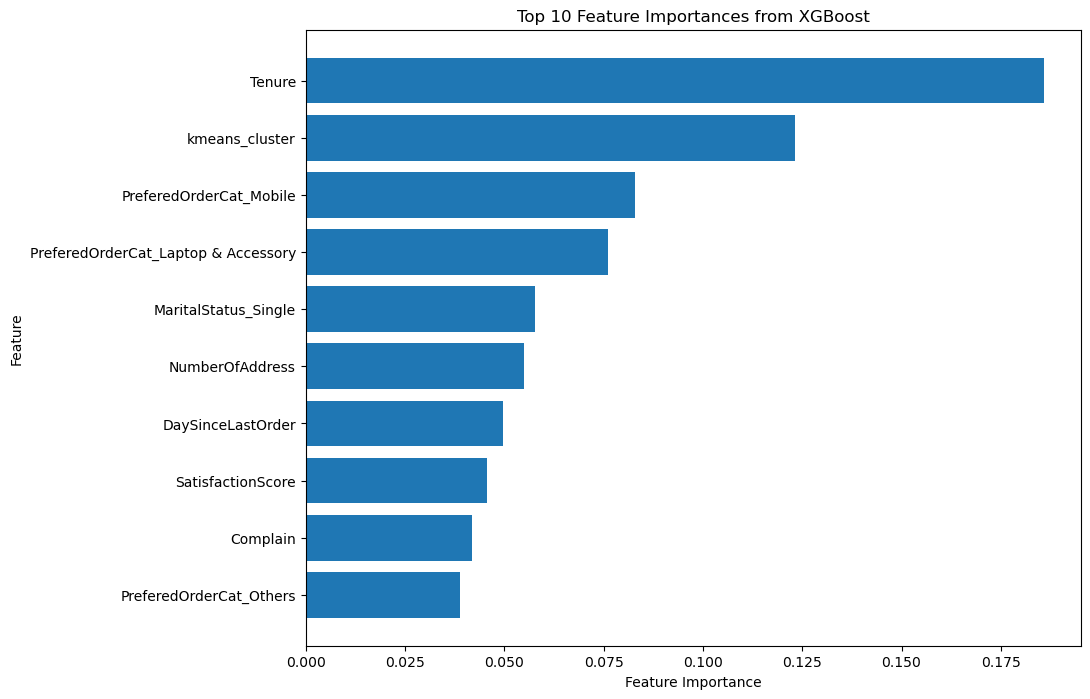

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Fit the best model
best_model.fit(X_train, y_train)

# Get feature importances
feature_importances = best_model.named_steps['model'].feature_importances_

# Get transformed feature names from the preprocessor
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
numerical_feature_names = numerical_features

# Combine feature names
all_feature_names = np.concatenate((numerical_feature_names, categorical_feature_names))

# Add KMeans clusters to feature names
all_feature_names = np.append(all_feature_names, ['kmeans_cluster'])

# Handle 'passthrough' features
passthrough_features = best_model.named_steps['preprocessor'].transformers_[-1][-1]  # Get passthrough columns

# Assuming the original dataframe is available as df
# Convert passthrough feature indices to column names
if passthrough_features is not None:
    if isinstance(passthrough_features, list):
        passthrough_feature_names = X_train.columns[passthrough_features].tolist()
    elif isinstance(passthrough_features, slice):
        passthrough_feature_names = X_train.columns[passthrough_features].tolist()
    else:
        passthrough_feature_names = [X_train.columns[passthrough_features]]
    all_feature_names = np.append(all_feature_names, passthrough_feature_names)

# Ensure all feature names are strings
all_feature_names = all_feature_names.astype(str)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get top 10 features
top_10_features = importance_df.head(10)

# Plot top 10 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from XGBoost')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


**`Tenure` as Top 1 Features Importance**

This feature holds the highest importance in the model. Tenure indicates the length of time a customer has subscribed to the e-commerce service. The longer the customers stay subscribed, the less likely they are to churn. The importance of this feature suggests that customers who have been subscribed for a long time tend to be more loyal.

<hr>

## <center>**Deployment**

<hr>

> #### **Deployment Plan**

The final model will be deployed where it will predict customer churn in real-time. The deployment plan includes:

- Setting up an API for real-time predictions
- Monitoring model performance
- Regularly retraining the model with new data to maintain its accuracy

> #### **Export Model**

In [93]:
import pickle

# Fit the best model on the entire dataset
best_model.fit(X, y)  # FINAL MODEL

# Save the model to a file
filename = 'Machine_Learning_Prediction_Churn.sav'  # Changed file extension to .sav
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)  # Save the best_model to file


<hr>

## <center>**Conclusion & Recommendation**

<hr>

In [68]:
display(df_default_test)
print(f'Model Name: XGBoost\n {class_report_testing[0]}')

,Algorithm,ROC AUC Score,F1 Score
0,XGBoost,0.956677,0.835341


Model Name: XGBoost
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       654
           1       0.91      0.77      0.84       135

    accuracy                           0.95       789
   macro avg       0.93      0.88      0.90       789
weighted avg       0.95      0.95      0.95       789



> ### **Conclusion**

Based on the classification report results from the model:

- **F1 Score**: The F1 score is 0.84 for the positive class (churn). The F1 score considers both precision and recall, providing a balanced measure of the model's accuracy. With an F1 score of 0.84, the model demonstrates a good balance between precision (0.91) and recall (0.77), indicating that it performs reasonably well in identifying customers who will churn.

- **ROC AUC Score**: The ROC AUC score is 0.956677. This score measures the model's ability to distinguish between the positive and negative classes. A score of 0.956677 indicates that the model has an excellent ability to differentiate between customers who will churn and those who will not. The closer the ROC AUC score is to 1, the better the model is at making this distinction.

**Interpretation**:
- If we implement this model, it will effectively identify customers who are likely to churn with a good balance of precision and recall, as reflected in the F1 score of 0.84. This means that, overall, the model is reliable in predicting churn without being overly biased towards either false positives or false negatives.
- The high ROC AUC score of 0.956677 suggests that the model is highly capable of distinguishing between customers who will churn and those who will not, which is crucial for targeting retention strategies effectively.

In summary, the model's performance, indicated by a strong F1 score and a high ROC AUC score, shows it is well-suited for predicting customer churn, though there is room for further improvement to reduce unnecessary interventions.

> ### **Model Limitation**

This model can only be used within the data range used in this modeling, which is:

| Feature                  | Data Type | Limitation                                                                                 |
|--------------------------|-----------|--------------------------------------------------------------------------------------------|
| `Tenure`                 | Float     | Length of subscription in months in the range 0-72                                         |
| `WarehouseToHome`        | Float     | Distance between warehouse to home in kilometers in the range 1-50                         |
| `NumberOfDeviceRegistered` | Integer  | Number of registered devices in the range 1-5                                              |
| `PreferedOrderCat`       | String    | Preferred order category: 'Laptop & Accessory', 'Mobile', 'Fashion', 'Others', etc.        |
| `SatisfactionScore`      | Integer   | Customer satisfaction score in the range 1-5                                               |
| `MaritalStatus`          | String    | Marital status: 'Single', 'Married', 'Divorced', etc.                                      |
| `NumberOfAddress`        | Integer   | Number of registered addresses in the range 1-10                                           |
| `Complain`               | Integer   | Whether the customer has filed a complaint or not in the range 0-1                         |
| `DaySinceLastOrder`      | Float     | Number of days since the last order in the range 0-365                                     |
| `CashbackAmount`         | Float     | Amount of cashback in USD in the range 0-500                                               |
| `Churn`                  | Integer   | Whether the customer has churned or not in the range 0-1                                   |



> ### **Recommendation**

To further improve the model, the following recommendations are suggested:

ModelRecommendation:

- Explore Other Models:
Test others models and combine the predictions of multiple models using ensemble methods like stacking, bagging, or boosting.

- Feature Engineering:
Create new features by combining existing ones or using domain knowledge. Use techniques like SelectKBest, Recursive Feature Elimination (RFE), or L1 regularization (Lasso) to identify and select the most relevant features.

- Outliers:
Cap or floor extreme values to reduce their impact while preserving data points.

By implementing these strategies, the model's performance and robustness can be enhanced, leading to more accurate predictions and better decision-making for mitigating customer churn.



Business Recomendation:
- Data-Driven Campaigns:
Use the data from your customer analytics to identify segments at risk of churn and create tailored promotional campaigns for each segment.

- Personalized Messaging:
Craft personalized messages for your promotional campaigns to make customers feel valued and understood. Use their purchase history and preferences to tailor the promotions.

- Proactive Engagement:
Engage with customers proactively before they show signs of churn. Regularly offer promotions, exclusive deals, and personalized recommendations to keep them engaged.

- Feedback Loop:
Establish a feedback loop where customers can share their experiences, and use this feedback to continuously improve your services and promotional strategies.
By leveraging these promotional strategies, you can mitigate churn effectively, retain your customers, and enhance their overall satisfaction and loyalty to your e-commerce platform.

<hr>
<hr>